# 水果辨識及價格
1. 為了將模型放入手機之中，因此選擇參數較少且運算速度較快的 MobileNet，同時準確度不會太差  
2. 從 keras 匯入 MobileNetV2 並將欠面幾層凍結只訓練後面13層
3. 最後將檔案儲存成tflite檔，利用找到的demo檔案將模型及標籤放入我們自己的
4. 利用Android studio 去 build 一個 project 並且執行它

## 1. 匯入套件及模型

In [15]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt

In [7]:
mobile = MobileNetV2()

In [8]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## 2. 資料處理

In [9]:
# 將訓練資料以Generator形式呈現
train_datagen=image.ImageDataGenerator(preprocessing_function=preprocess_input) 
train_generator=train_datagen.flow_from_directory(r"C:\Users\j3192\Desktop\Jupyter Notebook\計算機程式\fruit_data\train",
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                batch_size=50,
                                                class_mode='categorical',
                                                shuffle=True)

Found 39906 images belonging to 15 classes.


In [10]:
# 將測試資料以Generator形式呈現
test_datagen = image.ImageDataGenerator(preprocessing_function = pr eprocess_input)
test_generator = test_datagen.flow_from_directory(r'C:\Users\j3192\Desktop\Jupyter Notebook\計算機程式\fruit_data\test',
                                                 target_size = (224, 224),
                                                 color_mode = 'rgb',
                                                 batch_size = 50,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

Found 4500 images belonging to 15 classes.


## 3. 建立模型

In [11]:
# 將MobileNet前面幾層凍結只訓練後面13層
for layer in mobile.layers[:-13]:
    layer.trainable = False

In [12]:
# 因為原本MobileNet可以辨識1000種類的東西，但我們只有15種水果，因此將後面幾層刪除並新增最後輸出為15種類
x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)
pre = Dense(15, activation='softmax')(x)
new_model = Model(mobile.input, pre)

In [13]:
new_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

## 4. 訓練資料

In [16]:
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.01, mode='max', patience = 2)
history = new_model.fit_generator(generator = train_generator, 
                                  epochs = 8,
                                  callbacks = [early_stopping],
                                  validation_data = test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 799 steps, validate for 90 steps
Epoch 1/8
799/799 [==============================] - 1612s 2s/step - loss: 0.0673 - accuracy: 0.9798 - val_loss: 0.9537 - val_accuracy: 0.8209
Epoch 2/8
799/799 [==============================] - 1370s 2s/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.4132 - val_accuracy: 0.8958
Epoch 3/8
799/799 [==============================] - 1374s 2s/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 2.2638 - val_accuracy: 0.7116
Epoch 4/8
799/799 [==============================] - 1369s 2s/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 1.4403 - val_accuracy: 0.7809
Epoch 5/8
799/799 [==============================] - 1372s 2s/step - loss: 0.0088 - accuracy: 0.9968 - val_loss: 0.7571 - val_accuracy: 0.8611
Epoch 6/8
799/799 [==============================] - 1352s 2s/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 1.7

(0.6, 1.1)

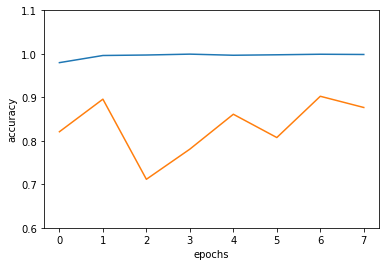

In [18]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0.6, 1.1)

(0, 2.5)

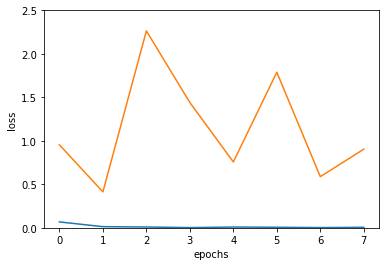

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2.5)

## 5. 網路爬蟲水果價格

In [20]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [21]:
df = pd.DataFrame({})
L = ['熱帶水果', '硬核類', '高山類', '厚皮類', '薄皮類', '瓜類', '柑橘柚類']
for category in L:
    res = requests.get(f'https://www.twfood.cc/topic/fruit/{category}')
    soup = BeautifulSoup(res.text, 'html.parser')
    fruit = soup.select('#vege_chart > div.col-xs-12.col-sm-12.col-md-3.widget.to_animate.animated.fadeInLeft > div > div.col-xs-6.col-sm-6.col-md-12.vege_price')
    names = soup.select('#vege_chart > div.col-xs-12.col-sm-12.col-md-3.widget.to_animate.animated.fadeInLeft > div > div.col-xs-6.col-sm-6.col-md-12.vege_price > h4 > a')
    num = len(fruit)
    for i in range(num):
        name = names[i].text.replace(" ", "").replace(f'推薦No:{i+1}', '').strip()
        estimated_price = fruit[i].find_all('span', {'class':'text-price'})[3].text
        ser = pd.Series({"estimated_price":estimated_price}, name = name)
        df = df.append(ser)
df = df.astype('float64')

## 6. 結果測試

In [30]:
result = new_model.predict(test_generator)

In [22]:
from ipywidgets import interact_manual

In [23]:
class_names = ['蘋果', '香蕉', '楊桃', '芭樂', '奇異果', '芒果', '甜瓜', '橘子', '桃子', '水梨', '柿子', '火龍果', '李', '石榴', '番茄']

In [24]:
x_test = []
for j in range(3):
    L = [test_generator[i][0] for i in range(30*j, 30*(j+1))]
    res = list(np.array(L).reshape(1500, 224, 224, 3))
    x_test.extend(res)

In [50]:
class_names = ['蘋果', '香蕉', '楊桃', '芭樂', '奇異果', '芒果', '甜瓜', '橘子', '桃子', '梨', '柿子', '火龍果', '李', '刪掉', '番茄']
price = []
for cls in class_names:
    L = []
    for name in df.index:
        if (cls + '-' in name) or (f'({cls})' in name):
            L.append(df.loc[name, 'estimated_price'])
    price.append(np.array(L).mean())

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


In [51]:
def show(n):
    plt.imshow(x_test[n] + 0.5)
    print("預測：", class_names[np.where(result[n] == result[n].max())[0][0]])
    print('合理價格為：', price[np.where(result[n] == result[n].max())[0][0]])

In [53]:
from ipywidgets import interact_manual
interact_manual(show,  n = (0, 4500))

interactive(children=(IntSlider(value=2250, description='n', max=4500), Button(description='Run Interact', sty…

<function __main__.show(n)>